# Getting EEG Channel Order with Hilbert Curves

Transformers are inherently dependent on the sequence of the input data. Likewise, vision transformers and video vision transformers learn from spatial relationships between patches in the same way that transformers in NLP learn from the order of input tokens.

In the current project, we need to ensure that EEG channels are ordered in a way that maintains spatial continuity between electrodes. Furthermore, since there are multiple datasets with varying numbers of channels, we need to create a general method for obtaining this order that can be applied to any number of channels. Doing so would ensure that relative positions in orders of any length will always correspond to similar brain regions.

Essentially, we need a way to go from *2D locations* of electrodes placed on a scalp to a *1D order* of channels. 

In mathematics, this problem is solved with *Hilbert curves*; these are curves that are used to fill a square space. In other words, a Hilbert curve can map all points in 2D space onto a 1D line while maintaining continuity. In our case, we won't need to fill space completely - we'll only need to fill a 2D matrix that contains all EEG channels.


### Preparing 2D electrode matricies

We can begin by defining the matrix for the 32 electrodes used in the public DEAP dataset:

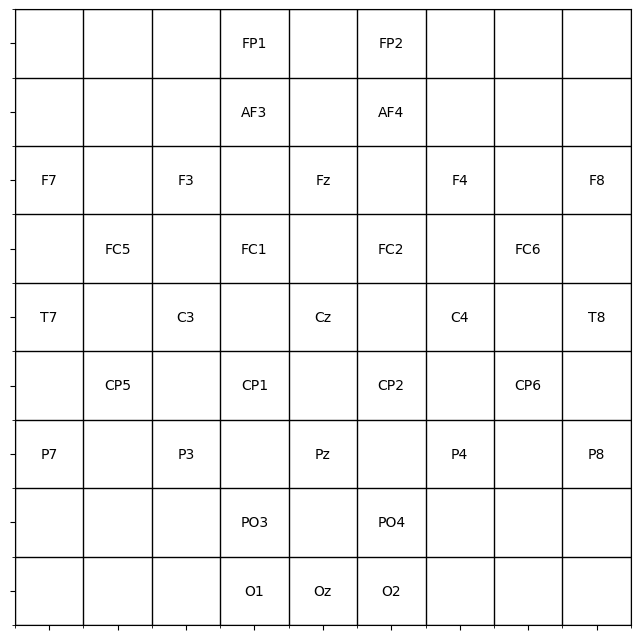

In [3]:
import matplotlib.pyplot as plt
import numpy as np

deap_electrode_matrix = [ # 9 x 9 square matrix
    ['', '', '', 'FP1', '', 'FP2', '', '', ''],
    ['', '', '', 'AF3', '', 'AF4', '', '', ''],
    ['F7', '', 'F3', '', 'Fz', '', 'F4', '', 'F8'],
    ['', 'FC5', '', 'FC1', '', 'FC2', '', 'FC6', ''],
    ['T7', '', 'C3', '', 'Cz', '', 'C4', '', 'T8'],
    ['', 'CP5', '', 'CP1', '', 'CP2', '', 'CP6', ''],
    ['P7', '', 'P3', '', 'Pz', '', 'P4', '', 'P8'],
    ['', '', '', 'PO3', '', 'PO4', '', '', ''],
    ['', '', '', 'O1', 'Oz', 'O2', '', '', '']
]

def plot_matrix(electrode_matrix, size=8):
    plt.close()
    matrix = np.array(electrode_matrix)

    fig, ax = plt.subplots(figsize=(size, size))

    # Plot text only
    for (i, j), label in np.ndenumerate(matrix):
        ax.text(j, i, label, ha='center', va='center', color='black', fontsize=10)

    # Setup the grid
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Add grid lines (cell borders)
    ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    # Turn off major grid
    ax.grid(False)

    # Set square aspect ratio
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.show()

plot_matrix(deap_electrode_matrix)

Creating a Hilbert curve requires a square with a side length of $2^n$, so we will pad the matrix with empty rows and columns to get a side length of 16

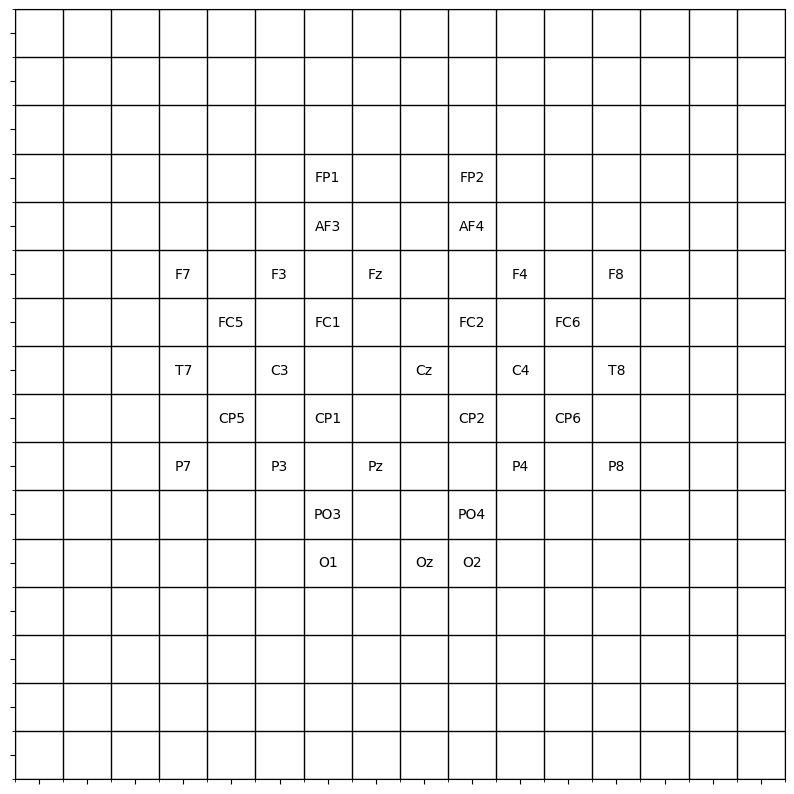

In [58]:
deap_electrode_matrix = [ # 9 x 9 square matrix
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', 'FP1', '', '', 'FP2', '', '', '', '', '', ''],
    ['', '', '', '', '', '', 'AF3', '', '', 'AF4', '', '', '', '', '', ''],
    ['', '', '', 'F7', '', 'F3', '', 'Fz', '', '', 'F4', '', 'F8', '', '', ''],
    ['', '', '', '', 'FC5', '', 'FC1', '', '', 'FC2', '', 'FC6', '', '', '', ''],
    ['', '', '', 'T7', '', 'C3', '', '', 'Cz', '', 'C4', '', 'T8', '', '', ''],
    ['', '', '', '', 'CP5', '', 'CP1', '', '', 'CP2', '', 'CP6', '', '', '', ''],
    ['', '', '', 'P7', '', 'P3', '', 'Pz', '', '', 'P4', '', 'P8', '', '', ''],
    ['', '', '', '', '', '', 'PO3', '', '', 'PO4', '', '', '', '', '', ''],
    ['', '', '', '', '', '', 'O1', '', 'Oz', 'O2', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
]

plot_matrix(deap_electrode_matrix, size=10)

With this size, we can also fit all 128 electrodes used in the private dataset:

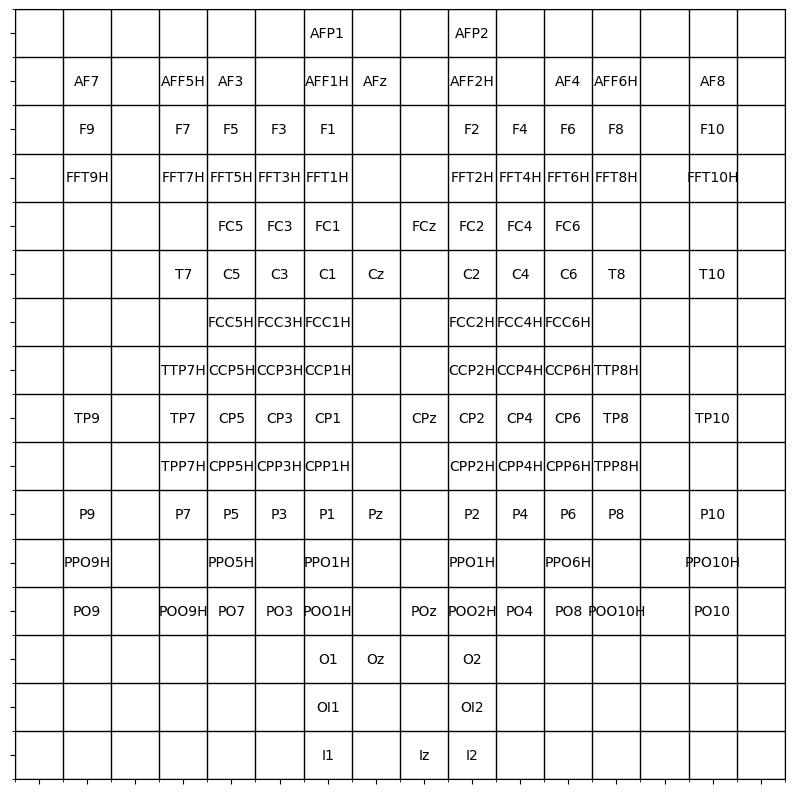

In [57]:
private_electrode_matrix = [
    # e   9   e   7   5   3   1   z   2   4   6   8   e  10   e
    ['', '', '', '', '', '', 'AFP1', '', '', 'AFP2', '', '', '', '', '', ''],
    ['', 'AF7', '', 'AFF5H', 'AF3', '', 'AFF1H', 'AFz', '', 'AFF2H', '', 'AF4', 'AFF6H', '', 'AF8', ''],
    ['', 'F9', '', 'F7', 'F5', 'F3', 'F1', '', '', 'F2', 'F4', 'F6', 'F8', '', 'F10', ''],
    ['', 'FFT9H', '', 'FFT7H', 'FFT5H', 'FFT3H', 'FFT1H', '', '', 'FFT2H', 'FFT4H', 'FFT6H', 'FFT8H', '', 'FFT10H', ''],
    ['', '', '', '', 'FC5', 'FC3', 'FC1', '', 'FCz', 'FC2', 'FC4', 'FC6', '', '', '', ''],
    ['', '', '', 'T7', 'C5', 'C3', 'C1', 'Cz', '', 'C2', 'C4', 'C6', 'T8', '', 'T10', ''],
    ['', '', '', '', 'FCC5H', 'FCC3H', 'FCC1H', '', '', 'FCC2H', 'FCC4H', 'FCC6H', '', '', '', ''],
    ['', '', '', 'TTP7H', 'CCP5H', 'CCP3H', 'CCP1H', '', '', 'CCP2H', 'CCP4H', 'CCP6H', 'TTP8H', '', '', ''],
    ['', 'TP9', '', 'TP7', 'CP5', 'CP3', 'CP1', '', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', '', 'TP10', ''],
    ['', '', '', 'TPP7H', 'CPP5H', 'CPP3H', 'CPP1H', '', '', 'CPP2H', 'CPP4H', 'CPP6H', 'TPP8H', '', '', ''],
    ['', 'P9', '', 'P7', 'P5', 'P3', 'P1', 'Pz', '', 'P2', 'P4', 'P6', 'P8', '', 'P10', ''],
    ['', 'PPO9H', '', '', 'PPO5H', '', 'PPO1H', '', '', 'PPO1H', '', 'PPO6H', '', '', 'PPO10H', ''],
    ['', 'PO9', '', 'POO9H', 'PO7', 'PO3', 'POO1H', '', 'POz', 'POO2H', 'PO4', 'PO8', 'POO10H', '', 'PO10', ''],
    ['', '', '', '', '', '', 'O1', 'Oz', '', 'O2', '', '', '', '', '', ''],
    ['', '', '', '', '', '', 'OI1', '', '', 'OI2', '', '', '', '', '', ''],
    ['', '', '', '', '', '', 'I1', '', 'Iz', 'I2', '', '', '', '', '', '']
    # e   9   e   7   5   3   1   z   2   4   6   8   e  10   e
]

plot_matrix(private_electrode_matrix, size=10)

### Creating the Hilbert Curve

By using the ```hilbertcurve``` Python package, we can get the order of coordinates traversed by the Hilbert curve for a 16 * 16 square

In [ ]:
from hilbertcurve.hilbertcurve import HilbertCurve

p = 4 # 2^4 = 16
N = 2 # 2 dimensions
hilbert_curve = HilbertCurve(p, N)
hilbert_coords = hilbert_curve.points_from_distances(list(range(16*16)))

Then, we can use those coordinates to determine the order of electrodes and plot the curve on the earlier matrices.

Channel order and Hilbert curve for DEAP dataset, 32 channels:
['O2', 'Oz', 'PO4', 'CP2', 'P4', 'CP6', 'P8', 'T8', 'F8', 'FP2', 'AF4', 'F4', 'FC6', 'C4', 'FC2', 'Cz', 'FC1', 'C3', 'FC5', 'F3', 'AF3', 'Fz', 'FP1', 'F7', 'T7', 'P7', 'CP5', 'P3', 'CP1', 'Pz', 'PO3', 'O1']


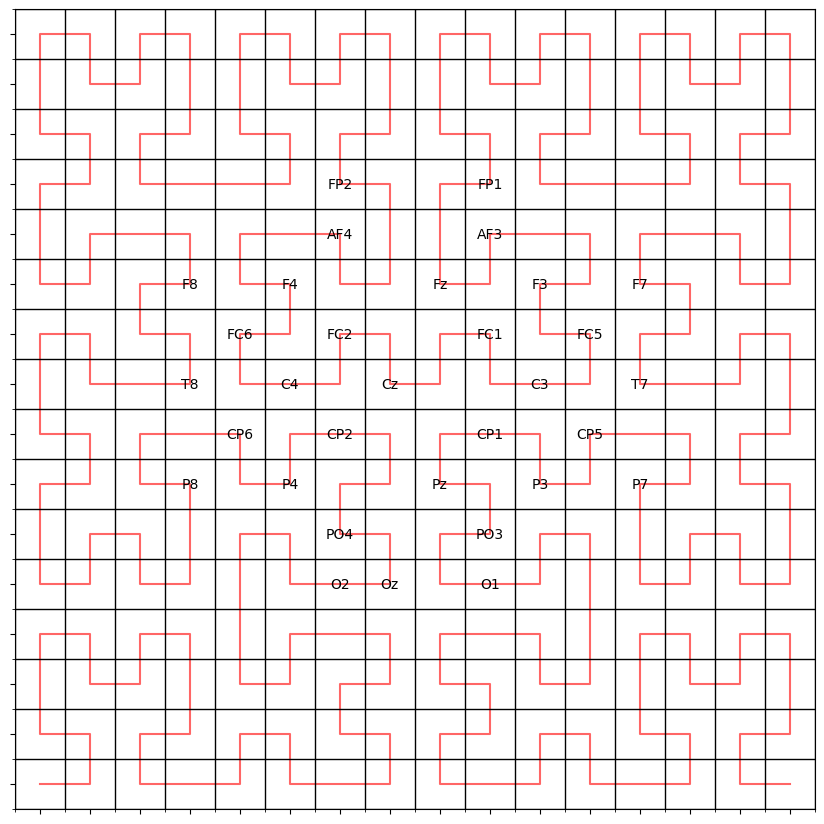



Channel order and Hilbert curve for Private dataset, 128 channels:
['PO10', 'POO10H', 'I2', 'Iz', 'OI2', 'O2', 'POz', 'POO2H', 'PO4', 'PO8', 'PPO6H', 'P6', 'P4', 'PPO1H', 'P2', 'CPP2H', 'CPz', 'CP2', 'CP4', 'CPP4H', 'CPP6H', 'CP6', 'TP8', 'TPP8H', 'P8', 'P10', 'PPO10H', 'TP10', 'TTP8H', 'T8', 'T10', 'FFT10H', 'F10', 'AF8', 'AFF6H', 'F8', 'FFT8H', 'FFT6H', 'FFT4H', 'F4', 'F6', 'AF4', 'AFF2H', 'AFP2', 'F2', 'FFT2H', 'FCz', 'C2', 'FC2', 'FC4', 'FC6', 'C6', 'C4', 'FCC4H', 'FCC6H', 'CCP6H', 'CCP4H', 'CCP2H', 'FCC2H', 'FCC1H', 'CCP1H', 'CCP3H', 'CCP5H', 'FCC5H', 'FCC3H', 'C3', 'C5', 'FC5', 'FC3', 'FC1', 'C1', 'Cz', 'FFT1H', 'F1', 'AFz', 'AFP1', 'AFF1H', 'AF3', 'F5', 'F3', 'FFT3H', 'FFT5H', 'FFT7H', 'F7', 'AFF5H', 'AF7', 'F9', 'FFT9H', 'T7', 'TTP7H', 'TP9', 'PPO9H', 'P9', 'P7', 'TPP7H', 'TP7', 'CP5', 'CPP5H', 'CPP3H', 'CP3', 'CP1', 'CPP1H', 'P1', 'Pz', 'PPO1H', 'P3', 'P5', 'PPO5H', 'PO7', 'PO3', 'POO1H', 'Oz', 'O1', 'OI1', 'I1', 'POO9H', 'PO9']


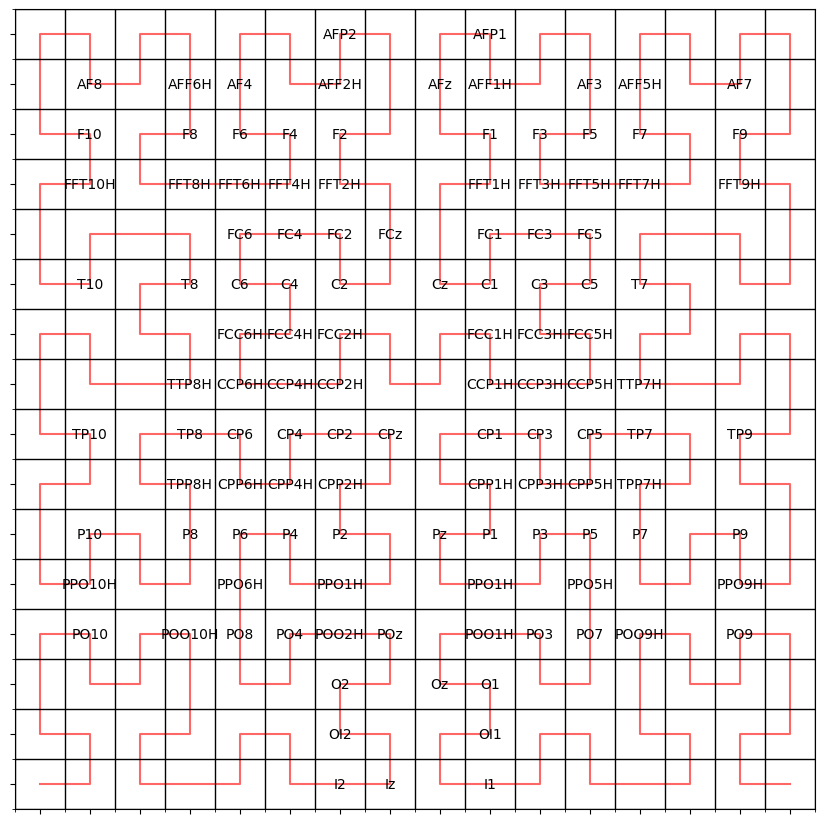

In [ ]:
def plot_matrix_with_curve(electrode_matrix, traversal_coords, size=8):
    plt.close()
    matrix = np.array(electrode_matrix)
    matrix = np.rot90(matrix, k=2)
    vector = [matrix[y, x] for x, y in traversal_coords]
    vector = [str(v) for v in vector if v != '']
    print(vector)
    fig, ax = plt.subplots(figsize=(size, size))

    for (i, j), label in np.ndenumerate(matrix):
        ax.text(j, i, label, ha='center', va='center', color='black', fontsize=10)

    xs = [x for x, y in traversal_coords]
    ys = [y for x, y in traversal_coords]
    ax.plot(xs, ys, color='red', linewidth=1.5, alpha=0.6, zorder=1)
    # ax.scatter(xs, ys, color='red', s=10, zorder=2)  # optional: dots at each point

    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.grid(False)

    ax.set_aspect('equal')
    ax.set_xlim(-0.5, matrix.shape[1] - 0.5)
    ax.set_ylim(matrix.shape[0] - 0.5, -0.5)
    ax.invert_yaxis()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

print("Channel order and Hilbert curve for DEAP dataset, 32 channels:")
plot_matrix_with_curve(deap_electrode_matrix, hilbert_coords, 8)
print("\n\nChannel order and Hilbert curve for Private dataset, 128 channels:")
plot_matrix_with_curve(private_electrode_matrix, hilbert_coords, 8)